In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from matplotlib.ticker import ScalarFormatter

In [2]:
%run 00_data_preprocessing.ipynb

In [3]:
dir_path = '../../results/main/03'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [4]:
def set_scientific_yticks(ax):
    """Force y-axis to show scientific notation in 10^x format"""
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Figure S3

In [5]:
B16_fucci = pd.read_csv("../../data/tumor/B16_fucci.csv")
B16_fucci.tail()

,Experiment,Condition,id,day,tumor_volume
193,B16-fucci,TST_2.0×10^7,2,7,32.6
194,B16-fucci,TST_2.0×10^7,3,7,196.6
195,B16-fucci,TST_2.0×10^7,4,7,219.7
196,B16-fucci,TST_2.0×10^7,5,7,106.5
197,B16-fucci,TST_2.0×10^7,6,7,7.3


In [6]:
B16_fucci['Condition'].unique()

array(['Untreated', 'TST_1.0×10^6', 'TST_2.0×10^6', 'TST_5.0×10^6',
       'TST_1.0×10^7', 'TST_2.0×10^7'], dtype=object)

In [7]:
# Condition mapping
condition_labels = {
    'Untreated': 'Untreated',
    'TST_1.0×10^6': r'$1.0 \times 10^{6}$',
    'TST_2.0×10^6': r'$2.0 \times 10^{6}$',
    'TST_5.0×10^6': r'$5.0 \times 10^{6}$',
    'TST_1.0×10^7': r'$1.0 \times 10^{7}$',
    'TST_2.0×10^7': r'$2.0 \times 10^{7}$'
}

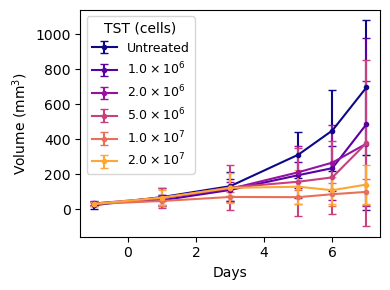

In [8]:
plt.figure(figsize=(4, 3))
colors = plt.cm.plasma(np.linspace(0, 0.8, len(B16_fucci['Condition'].unique())))

for i, cond in enumerate(B16_fucci['Condition'].unique()):
    plt.errorbar(
        tumor_volume(B16_fucci, cond)['day'],
        tumor_volume(B16_fucci, cond)['mean'],
        yerr=tumor_volume(B16_fucci, cond)['std'],
        label=condition_labels.get(cond, cond),   # ←ここで変換
        capsize=3, markersize=3, fmt='o-', color=colors[i]
    )
plt.legend(title="TST (cells)", fontsize=9, title_fontsize=10)
#plt.title('CTL Dose on B16F10-fucci')
plt.xlabel('Days')
plt.ylabel('Volume (mm$^3$)')

plt.tight_layout()
plt.savefig(os.path.join(dir_path, "figS3_fucci.pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(dir_path, "figS3_fucci.png"), dpi=300, bbox_inches='tight')

# Figure 3

In [9]:
t_start = 2  # Delay (in days) before CTLs infiltrate the tumor after injection

def ctl_pulse(t, dose_list, dose_days, delta_t):
    """Return the CTL input function F(t), based on dose schedule and delivery window."""
    total = 0
    for dose, day in zip(dose_list, dose_days):
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

In [10]:
# Model: Saturable Suppression by MDSCs
def model(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = ctl_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v)  - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [11]:
def vis_act(sol, out_dir=None, figure_name=None):
    V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
    T_sol = E_sol + D_sol

    # === Plot ===
    plt.figure(figsize=(16, 4), dpi=200)
    plt.rcParams["font.size"] = 12

    # --- Panel A: Tumor volume ---
    ax1 = plt.subplot(1, 4, 1)
    ax1.plot(t_eval, V_sol, label='Model', color='blue', linewidth=2)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("B16 (cells)")
    ax1.set_title("B16 Dynamics")
    ax1.legend()
    set_scientific_yticks(ax1)

    # --- Panel B: MDSC ---
    ax2 = plt.subplot(1, 4, 2)
    ax2.plot(t_eval, M_sol, label='Model', color='blue')
    ax2.set_xlabel("Days")
    ax2.set_ylabel("MDSC (cells)")
    ax2.set_title("MDSC Dynamics")
    ax2.legend()
    set_scientific_yticks(ax2)

    # --- Panel C: CTL ---
    ax3 = plt.subplot(1, 4, 3)
    ax3.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
    ax3.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
    ax3.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
    ax3.set_xlabel('Days')
    ax3.set_ylabel('TST (cells)')
    ax3.set_title('TST Dynamics')
    ax3.legend()
    set_scientific_yticks(ax3)

    # --- Panel D: Suppression Effect ---
    ax4 = plt.subplot(1, 4, 4)
    ax4.plot(t_eval, S_sol, label='Model', color='blue', linewidth=2)
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Tumor Suppression')
    ax4.set_title('Tumor Suppression')
    ax4.legend()
    set_scientific_yticks(ax4)

    plt.tight_layout()

    # === Save if out_dir is provided ===
    if out_dir is not None and figure_name is not None:
        os.makedirs(out_dir, exist_ok=True)
        pdf_path = os.path.join(out_dir, f"{figure_name}.pdf")
        jpeg_path = os.path.join(out_dir, f"{figure_name}.jpeg")
        plt.savefig(pdf_path, dpi=300)
        plt.savefig(jpeg_path, dpi=300)
        print(f"Figure saved: {pdf_path}, {jpeg_path}")

    plt.show()

# Param

In [12]:
param = np.array([
    1.3104e-07, 1.8338e+00, 1.9608e+00, 6.3755e-01,
    9.9399e-01, 8.9600e-01, 4.7826e+00, 3.1554e+07
])

In [13]:
# ==Fixed param ==
v_r = 9.99e-2
v_k = 1.64e+10
m_v = 4.87e-2
m_d = 3.06e-1

# Other article param
k_v = 2.02e7

# Fig 3a Simulation

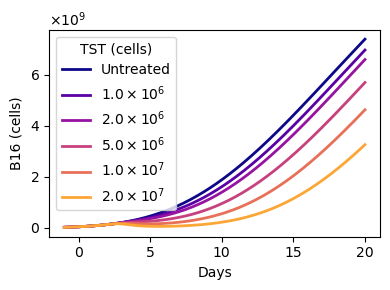

In [14]:
# Simulation Setup
t_eval = np.arange(-1, 20.01, 0.01)
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]

dose_days = [0]
delta_t   = 1   

# doses
dose_values = [0, 1e6, 2e6, 5e6, 1e7, 2e7]
results = {}

# --- Plot ---
plt.figure(figsize=(4, 3))
#plt.rcParams["font.size"] = 18

colors = plt.cm.plasma(np.linspace(0, 0.8, len(dose_values)))

for i, dose in enumerate(dose_values):
    dose_list = [dose]
    sol = odeint(model, y0, t_eval, args=(dose_list, dose_days, delta_t, param), hmax=0.001)
    V_sol = sol[:, 0]
    results[dose] = V_sol

    # --- 修正: legend label を LaTeX表記に ---
    if dose == 0:
        labels = "Untreated"
    else:
        exponent = int(np.log10(dose))
        coeff = dose / 10**exponent
        labels = fr"$ {coeff:.1f} \times 10^{{{exponent}}}$"
    plt.plot(t_eval, V_sol, label=labels, color=colors[i], linewidth=2)
    
plt.xlabel('Days')
plt.ylabel('B16 (cells)')

# === apply scientific notation on y-axis ===
ax = plt.gca()
set_scientific_yticks(ax)

plt.legend(title='TST (cells)', fontsize=10)#, loc='center left', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

pdf_path = os.path.join(dir_path, f"fig3a.pdf")
jpeg_path = os.path.join(dir_path, f"fig3a.jpeg")
plt.savefig(pdf_path, dpi=300)
plt.savefig(jpeg_path, dpi=300)
plt.show()

# Fig 3b 

In [15]:
def format_sci(value):
    """a × 10^b"""
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(value)))
    coeff = value / 10**exponent
    return fr"{coeff:.1f} \times 10^{{{exponent}}}"

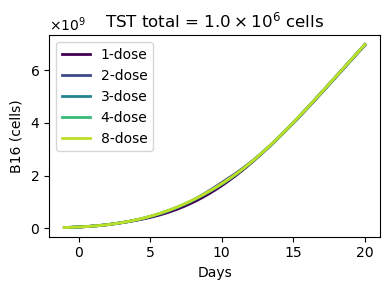

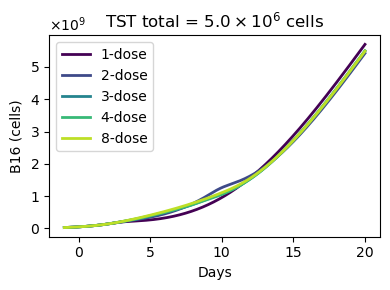

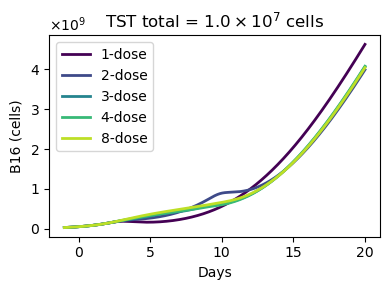

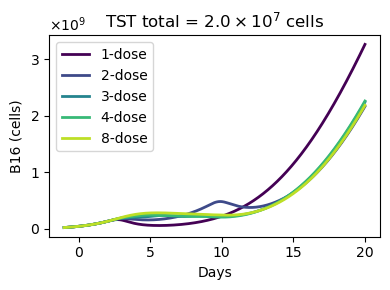

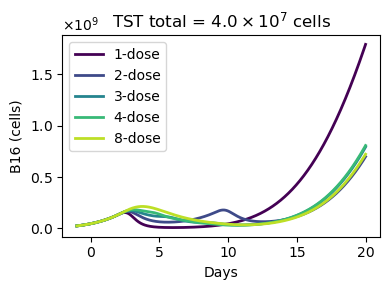

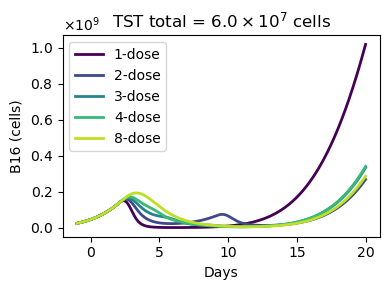

In [16]:
# === Dosing schedule ===
t_eval = np.arange(-1, 20.01, 0.01)
total_dose_list = [1e6, 5e6, 1e7, 2e7, 4e7, 6e7]
for total_dose in total_dose_list:
    dose_schedules = {
        "1-dose": ([0], [total_dose]),
        "2-dose": ([0, 7], [total_dose/2]*2),
        "3-dose": ([0, 3, 6], [total_dose/3]*3),
        "4-dose": ([0, 2, 4, 6], [total_dose/4]*4),
        "8-dose": ([0, 1, 2, 3, 4, 5, 6, 7], [total_dose/8]*8)
    }
    
    # === Simulation ===
    plt.rcParams["font.size"] = 10
    
    plt.figure(figsize=(4, 3))
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(dose_schedules)))
    
    for (label, (days, doses)), color in zip(dose_schedules.items(), colors):
        t_eval = np.arange(-1, 20.01, 0.01)
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param), hmax=0.001)
        V_sol = sol[:, 0]
        plt.plot(t_eval, V_sol, label=label, color=color, linewidth=2)
    
    plt.xlabel('Days')
    plt.ylabel('B16 (cells)')
    #plt.yscale('log')

    sci_title = format_sci(total_dose)
    plt.title(fr"TST total = ${sci_title}$ cells")
    plt.legend(title="Schedule")
    plt.tight_layout()

    # === apply scientific notation on y-axis ===
    ax = plt.gca()
    set_scientific_yticks(ax)

    plt.legend(fontsize=10)#, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.tight_layout()

    # --- Save ---
    filename_base = f"{int(total_dose):.0e}".replace("+0", "").replace(".0", "").replace("e", "e")
    #plt.savefig(os.path.join(save_dir_3_1, f"{filename_base}_dose.pdf"), dpi=300, bbox_inches='tight')
    #plt.savefig(os.path.join(save_dir_3_1, f"{filename_base}_dose.png"), dpi=300, bbox_inches='tight')
    pdf_path = os.path.join(dir_path, f"fig3b_{filename_base}_dose.pdf")
    jpeg_path = os.path.join(dir_path, f"fig3b_{filename_base}_dose.jpeg")
    plt.savefig(pdf_path, dpi=300)
    plt.savefig(jpeg_path, dpi=300)

# Fig 3C

In [17]:
# Baseline volume at reference_time (Day 3)
reference_time = t_start + delta_t  # 2 + 1 = 3 days
sol_base = odeint(model, y0, t_eval, args=([0], [0], delta_t, param))
V_ref = np.interp(reference_time, t_eval, sol_base[:, 0])

# Fine-grained parameter grid
second_days = np.arange(0, 10, 1)          # Days 0 to 10
second_doses = np.arange(5e6, 4.1e7, 0.5e7)
#   # Doses from 0.5e7 to 4.0e7 in steps of 0.5e7

pfs_matrix_2 = np.zeros((len(second_doses), len(second_days)))

# Compute PFS for each combination
for i, dose2 in enumerate(second_doses):
    for j, day2 in enumerate(second_days):
        doses = [1e7, dose2]
        days = [0, int(day2)]
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param), hmax=0.001)
        V = sol[:, 0]
        mask = (t_eval > reference_time) & (V >= V_ref)
        pfs_matrix_2[i, j] = (np.min(t_eval[mask]) - reference_time) if np.any(mask) else (t_eval[-1] - reference_time)

# Prepare DataFrame
pfs_df_new_2 = pd.DataFrame(pfs_matrix_2, 
                      index=[f"{d/1e7:.1f}e7" for d in second_doses],
                      columns=[f"Day {int(d)}" for d in second_days])

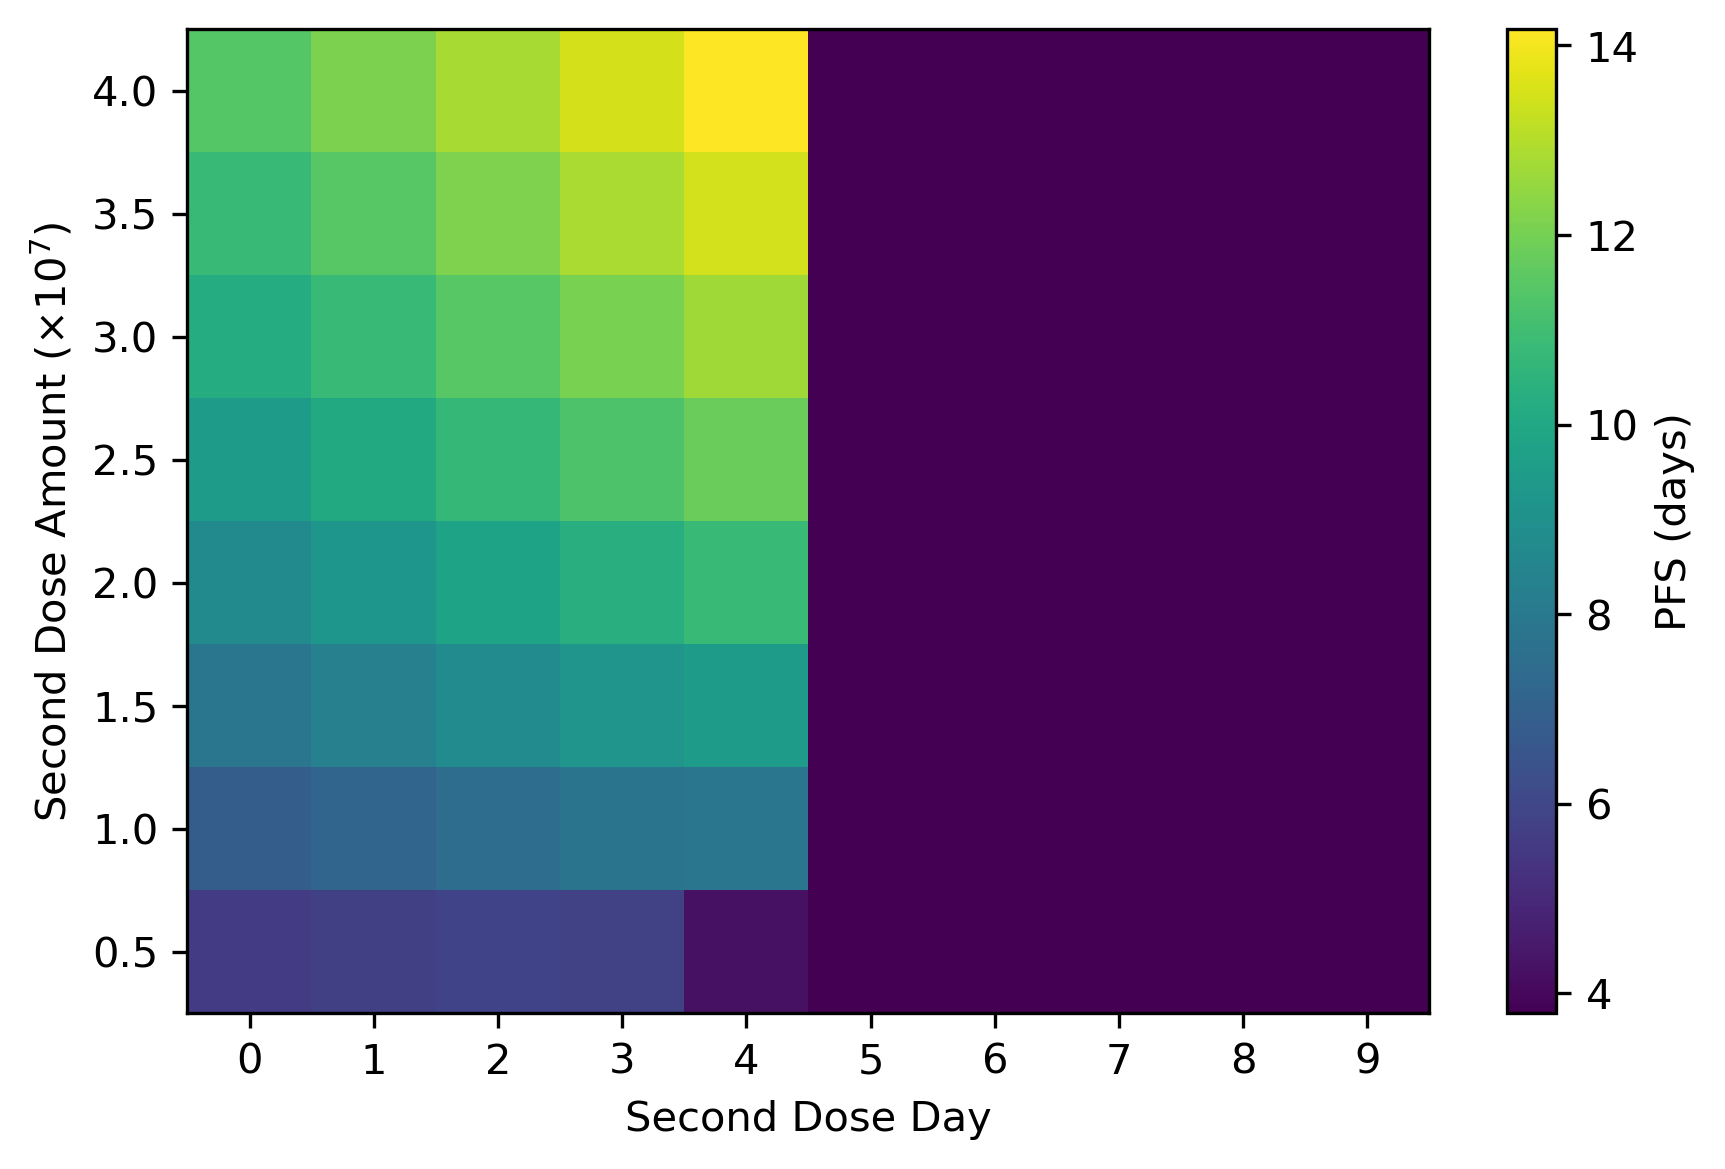

In [18]:
plt.figure(figsize=(6, 4), dpi=300)
plt.imshow(pfs_matrix_2, origin='lower', aspect='auto')
plt.colorbar(label='PFS (days)')

plt.xticks(np.arange(len(second_days)), second_days)
yticklabels = [f"{d/1e7:.1f}" for d in second_doses]
plt.yticks(np.arange(len(second_doses)), yticklabels)
plt.xlabel('Second Dose Day')
plt.ylabel('Second Dose Amount ($\\times 10^7$)')

#plt.title('Figure 3D: Fine-Grained PFS Heatmap (Baseline Day 3)')
plt.tight_layout()
plt.show()


In [19]:
# Simulation settings
t_eval = np.arange(-1, 35.01, 0.01)
y0 = [2.4977280e7, 0, 0, 0, 1.306390e6]

# Fine-grained parameter grid
second_days = np.arange(0, 10, 1)
second_doses = np.arange(0.5e7, 5.1e7, 0.5e7)

# Compute final tumor volume at end of simulation (t = max t_eval)
final_vol_matrix_2 = np.zeros((len(second_doses), len(second_days)))

for i, dose2 in enumerate(second_doses):
    for j, day2 in enumerate(second_days):
        doses = [1e7, dose2]
        days = [0, int(day2)]
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param))
        final_vol_matrix_2[i, j] = sol[-1, 0]

# Create DataFrame for display
final_df_2 = pd.DataFrame(final_vol_matrix_2,
                        index=[f"{d/1e7:.1f}e7" for d in second_doses],
                        columns=[f"Day {int(d)}" for d in second_days])

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1195275909265D-15


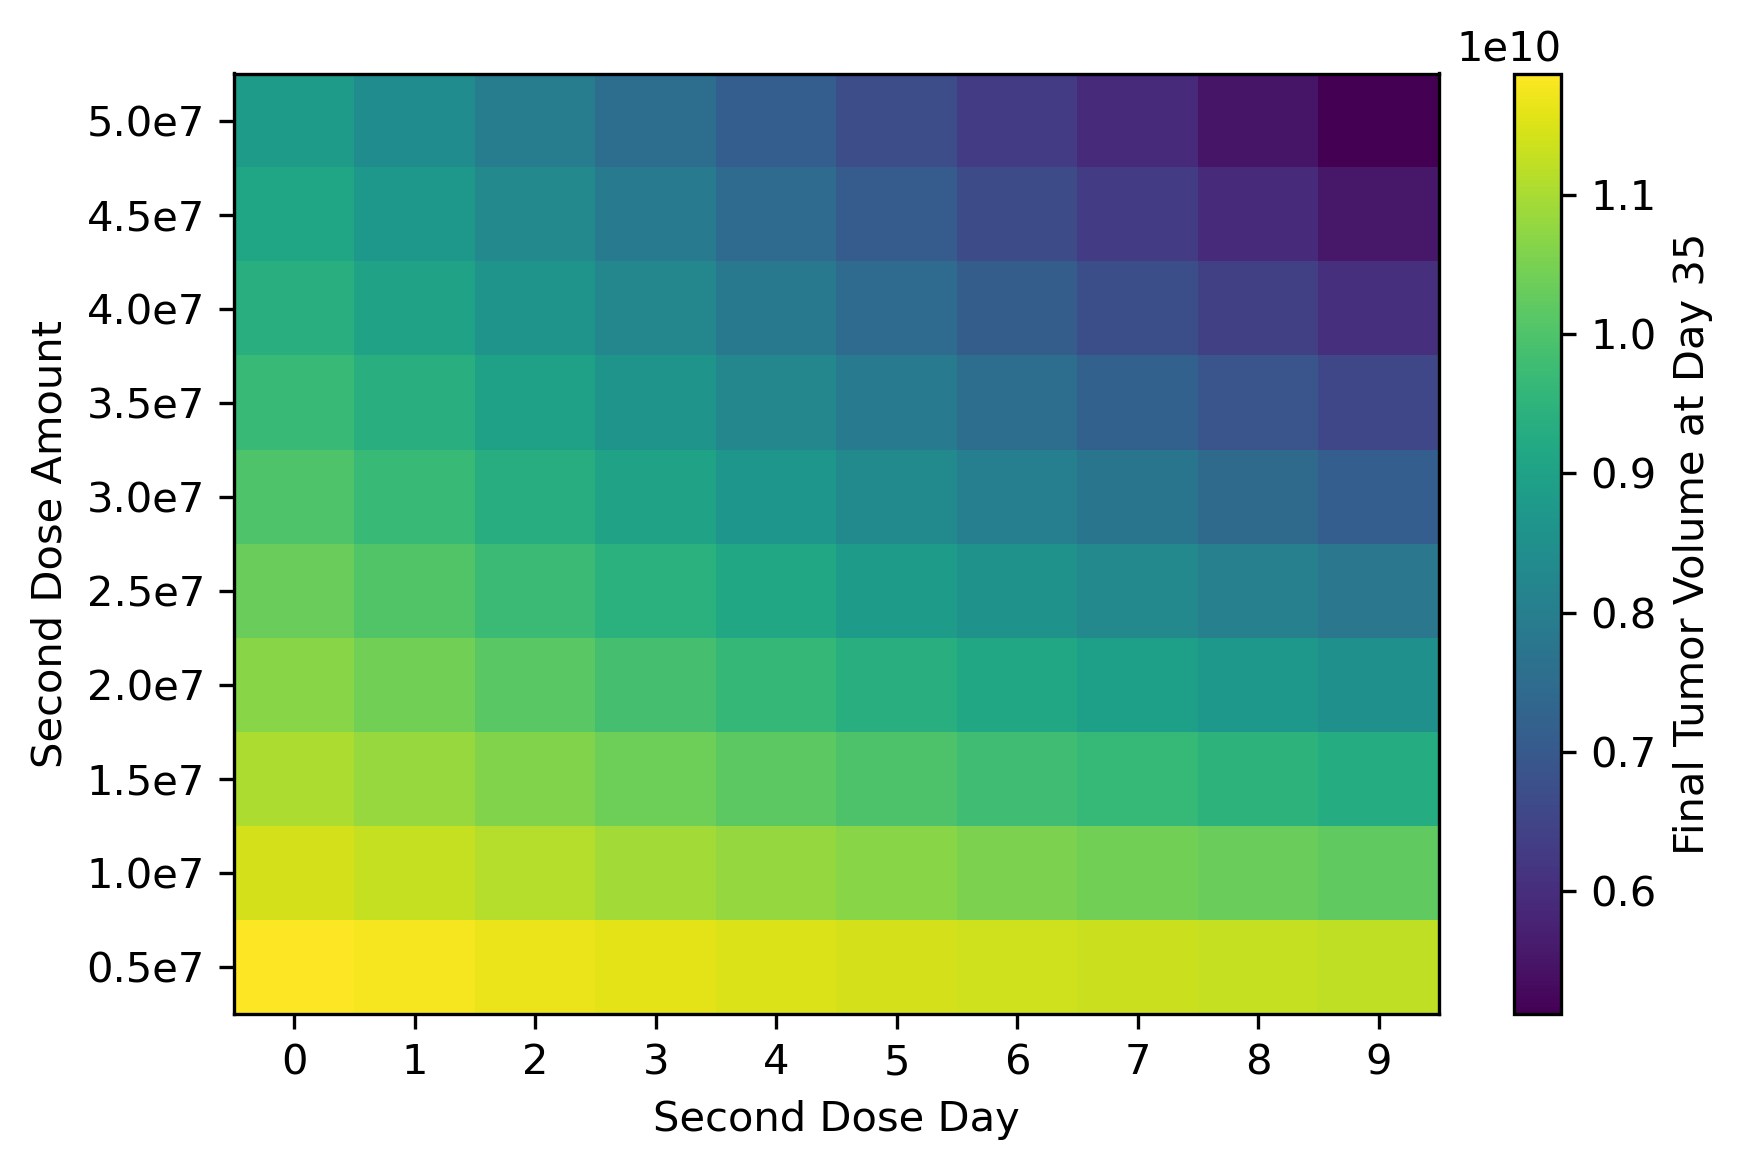

In [20]:
# Plot heatmap
plt.figure(figsize=(6, 4), dpi=300)
plt.imshow(final_vol_matrix_2, origin='lower', aspect='auto')
plt.colorbar(label='Final Tumor Volume at Day 35')
plt.xticks(np.arange(len(second_days)), second_days)
plt.yticks(np.arange(len(second_doses)), [f"{d/1e7:.1f}e7" for d in second_doses])
plt.xlabel('Second Dose Day')
plt.ylabel('Second Dose Amount')
#plt.title('Tumor Volume Heatmap at Day 35')
plt.tight_layout()
plt.show()

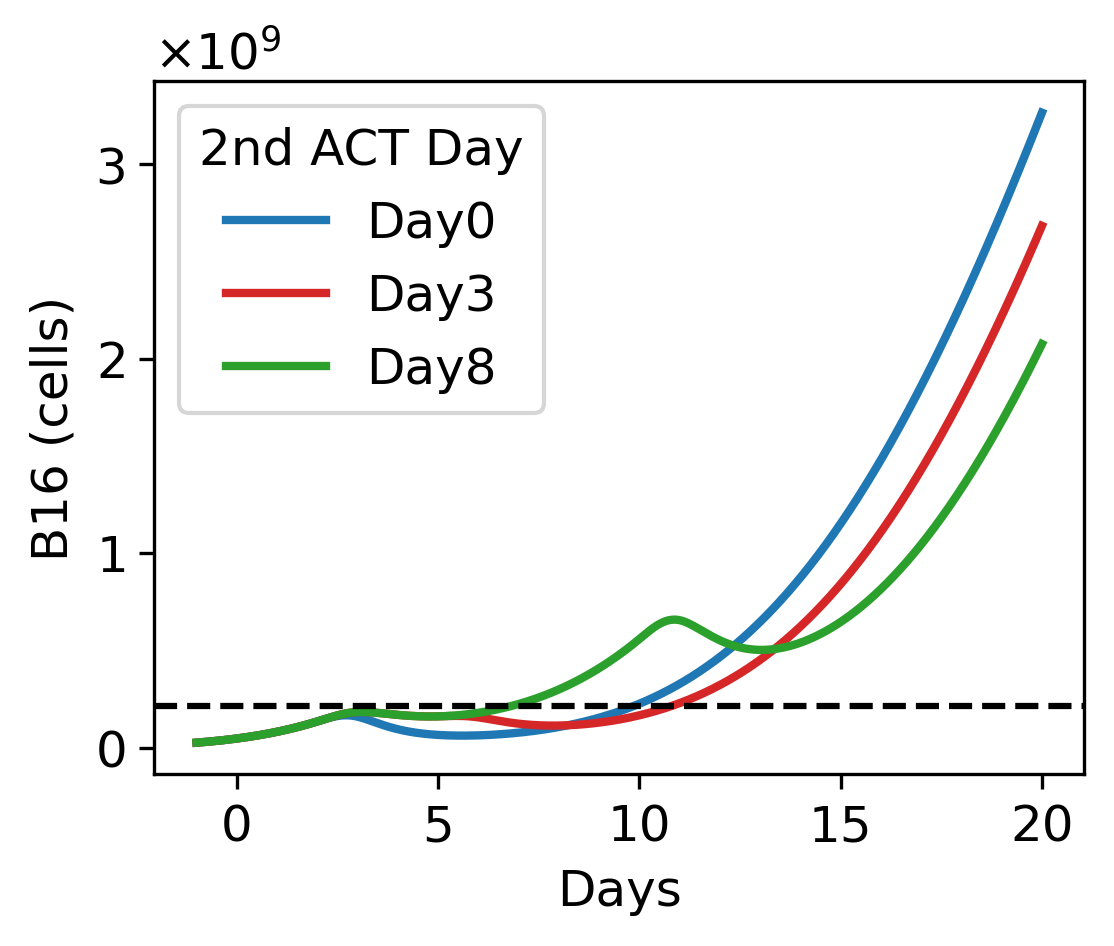

In [21]:
# Time range
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]] # y = [V, E, D, S]
t_eval = np.arange(-1, 20.01, 0.01)

# === Pattern1 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 0]    
delta_t = 1        
sol = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
T_sol = E_sol+D_sol

# === Pattern2 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 3]    
delta_t = 1        
sol2 = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

# === Pattern3 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 8]    
delta_t = 1        
sol3 = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol3, E_sol3, D_sol3, S_sol3, M_sol3 = sol3.T
T_sol3 = E_sol3+D_sol3

# === Plot ===
plt.figure(figsize=(4, 3), dpi=300)
plt.rcParams["font.size"] = 12
# --- Panel A: Tumor volume ---
#plt.title('A', loc='left', fontsize=20, fontweight='bold', position=(-0.2,1))
plt.plot(t_eval, V_sol, label='Day0', color='tab:blue', linewidth=2)
plt.plot(t_eval, V_sol2, label='Day3', color='tab:red', linewidth=2)
plt.plot(t_eval, V_sol3, label='Day8', color='tab:green', linewidth=2)
#plt.yscale('log')
plt.axhline(V_ref, linestyle="--", color="black")
plt.xlabel("Days")
plt.ylabel("B16 (cells)")
plt.legend(title='2nd ACT Day')
ax = plt.gca()
set_scientific_yticks(ax)